# Airbnb data analysis
**For review purposes:** http://nbviewer.jupyter.org/github/SilvrDuck/CS-401/blob/master/project/Project.ipynb

## Introduction

The massive adoption of the Airbnb service in the world has changed the way people travel, and how the hotel industry works. There is a lot of controversy about this service. The City of Berlin chose to ban the service entirely, and later made exception allowing people having only a secondary residency there to rent it, but for a limited amount of time per year. In the case of Amsterdam, a deal has been made directly with the company to limit the number of days that any given apartment can be rented.

But what are the concerns here? Is it the hotel industry that suffers? Are the denizens of those cities directly threatened by rises in housing prices and speculation? In this work, we want to explore the data offered by the website http://insideairbnb.com/. We will try not to take any conclusion beforehand and simply try to find correlation between the usage of the housing service and different indicators published by the national statistics service themselves.

We chose to do those analysis on the two aforementioned cities, Berlin and Amsterdam, since they are both major touristic capitals in Europe, and quite close to each other. Comparing the two might help us have more insight on the effect of the business. The two cities have put in place major regulation on the service in 2016. We will therefore compare analyse the evolution of those factor between 2015 and 2017.

## Inside Airbnb data imports and helper functions definitions

Here we load and prepare the date for analysis of the Inside Airbnb corpus.

In [1]:
%matplotlib inline

import os
import folium
import numpy  as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

DATASETS_ROOT="datasets"
INSIDE="Inside-Airbnb"
NATIONAL="National"
CITIES=["Amsterdam", "Berlin"]

The following two function create and return a folium map for Amsterdam and Berlin, those map can then be enhanced with other features

In [2]:
def load_amsterdam_geo():
    amsterdam_topo = os.path.join(DATASETS_ROOT, "Amsterdam", "neighbourhoods.geojson")
    m = folium.Map(
        location=[52.370216, 4.895168],
        zoom_start=12
    )

    folium.GeoJson(
        amsterdam_topo,
        name='geojson'
    ).add_to(m)
    
    return m

In [3]:
def load_berlin_geo():
    berlin_topo = os.path.join(DATASETS_ROOT, "Berlin", "neighbourhoods.geojson")
    m = folium.Map(
        location=[52.52437, 13.41053],
        zoom_start=11
    )

    folium.GeoJson(
        open(berlin_topo,  'r', encoding='utf-8').read(),
        name='geojson'
    ).add_to(m)
    
    return m

We have two dataset for each year of Airbnb, one with a lot of columns and features, and the other one with a subset of these features, we need to be able to load them both as a dataframe.

In [4]:
def load_listing(city, year, full = False):
    filename = "listings.csv" if not full else "listings 2.csv"
    file = os.path.join(DATASETS_ROOT, city, INSIDE, year, filename)
    return pd.read_csv(file)

In [5]:
def load_calendar_data(city, year):
    file = os.path.join(DATASETS_ROOT, city, INSIDE, year, "calendar.csv")
    return pd.read_csv(file)

def load_listing_data(city, year):
    pass

The following method creates a choropleth for a city given the starting map, a path to the GeoJSON file as well as a dataframe containing at least two columns:

- counts: the number of AirBnB
- neigbourhood: The name of the neigbourhood

In [6]:
def neighbourhood_map(start_map, path, stats, label):
    from shapely.geometry import Polygon, mapping
    
    geo_df = gpd.read_file(path)

    text = []
    list_geo = []
    gj = []

    for i in range(stats.index.size):
        current = stats.loc[i]
        selected = geo_df[geo_df['neighbourhood'] == current.neighbourhood]

        mp = mapping(selected.geometry)
        list_geo.append(selected)
        text.append(current.neighbourhood +  '<br>' + label + ': ' + str(current.counts))
        gj.append(folium.GeoJson(mp, style_function=lambda feature: {
            'opacity' : 0.7 , 'fillColor': '#FFFFFFFF', 'color' : 'blue'
        }))
    
    xs = sorted(stats.counts.tolist())
    L = len(xs)
    s = int(L/5)
    sublist = [xs[p:p+s] for p in range(0, L, s)]
   
    sublist = [sub[len(sub)-1]+1 for sub in sublist]

    start_map.choropleth(
        geo_data=open(path,  'r', encoding='utf-8').read(),
        name='choropleth',
        data=stats,
        columns=['neighbourhood', "counts"],
        fill_color='PuBuGn',
        fill_opacity=0.5,
        line_opacity=0.2,
        key_on='properties.neighbourhood',
        legend_name=label,
        threshold_scale=sublist
    )

    for i in range(geo_df.index.size):
        if i < len(text):
            gj[i].add_child(folium.Popup(text[i]))
            gj[i].add_to(start_map)
    return start_map

The data in the calendar have a $ prefix for the price as well as `,` instead of `.` for the numbers, we remove them from the dataframe in the next method

In [7]:
def clean_calendar(dataframe):
    # Listing ID is the rental ID, we need it as a string, not a number
    dataframe["listing_id"] = dataframe["listing_id"].apply(lambda x: str(x))

    # We remove the $ from the price and the , as well
    dataframe["price"] = dataframe["price"].apply(lambda p: p if isinstance(p, float) else float(p.replace('$', '').replace(',', '')))
    return dataframe

The followings methods can be run directly on any `listing` graph of the city to plot features

In [158]:
def mean_prices(df):
    result = df.groupby("date").mean().reset_index("date")
    result['date_wo_year'] = result["date"].apply(lambda x: str(x[5:]))
    return result

def plot_mean_prices(dataframe, label_1='2015', label_2='2017'):
    plt.figure(figsize=(15, 9))

    plt.ylabel("Mean price per day", fontsize=16)  

    labels = []
    for i in range(len(dataframe['date_wo_year'])):
        if i%7 == 0:
            labels.append(dataframe['date_wo_year'][i])
        else:
            labels.append("")

    plt.plot(dataframe['date_wo_year'], dataframe["price_x"], color="#008489", lw=2, label=label_1)
    plt.plot(dataframe['date_wo_year'], dataframe["price_y"], color="#ff5a5f", lw=2, label=label_2)
    plt.legend(loc='upper right')
    plt.xticks(range(len(labels)), labels, rotation = 90)

    plt.title("Mean price for AirBnB rentals per day", fontsize=22)
    plt.show()

In [159]:
bins = 15

def filter_hist_data(calendar):
    count = calendar.groupby('listing_id')['available'].apply(lambda x: (x=='t').sum()).reset_index(name='count')
    count = count[count['count'] != 0]
    return count['count']

def plot_availability_hist(calendar, calendar2):
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)

    sns.distplot(filter_hist_data(calendar), ax=ax, kde=False, label='2015', bins=bins)
    sns.distplot(filter_hist_data(calendar2), ax=ax, kde=False, label='2017', bins=bins)

    plt.title('Availability of AirBnB')

    ax.set(xlabel='Amount of available days', ylabel='Amount of AirBnB')

    plt.legend()
    plt.show()

We now can load each and every dataset (per city, per year) we will need for this project

In [10]:
amsterdam_calendar_data_2015 = load_calendar_data("Amsterdam", "2015")
amsterdam_calendar_data_2017 = load_calendar_data("Amsterdam", "2017")
# We have the same data and layout in the two dataframes (2015 and 2017) but the date contains the year.
# to match the data together, we first have to remove the year from the "date" column.
# The first step is to add a new column of the date without the year in both dataframe
amsterdam_calendar_data_2015['date_wo_year'] = amsterdam_calendar_data_2015["date"].apply(lambda x: str(x[5:]))
amsterdam_calendar_data_2017['date_wo_year'] = amsterdam_calendar_data_2017["date"].apply(lambda x: str(x[5:]))

amsterdam_listing_2015 = load_listing("Amsterdam", "2015")
amsterdam_listing_2017 = load_listing("Amsterdam", "2017")

amsterdam_listing_2015_full = load_listing("Amsterdam", "2015", True)
amsterdam_listing_2017_full = load_listing("Amsterdam", "2017", True)


amsterdam_calendar_data_2015 = clean_calendar(amsterdam_calendar_data_2015)
amsterdam_calendar_data_2017 = clean_calendar(amsterdam_calendar_data_2017)

In [11]:
berlin_calendar_data_2016 = load_calendar_data("Berlin", "2016")
berlin_calendar_data_2017 = load_calendar_data("Berlin", "2017")

berlin_listing_2016 = load_listing("Berlin", "2016")
berlin_listing_2017 = load_listing("Berlin", "2017")

berlin_listing_2016_full = load_listing("Berlin", "2016", True)
berlin_listing_2017_full = load_listing("Berlin", "2017", True)

berlin_calendar_data_2016 = clean_calendar(berlin_calendar_data_2016)
berlin_calendar_data_2017 = clean_calendar(berlin_calendar_data_2017)

## Exploring data from the Inside Airbnb dataset

### Berlin - Inside Airbnb

Here we display the density of usage of Airbnb across the different neighbourhood of the city.
The first step is to match neighbourhood from the GeoJSON and the listing.

Let's extract the neighbourhoods from the listing:

In [12]:
berlin_listing_ng_names = berlin_listing_2016.neighbourhood.unique()
berlin_listing_2016_neig_stats = berlin_listing_2016.groupby("neighbourhood").size().reset_index(name="counts")

We want to be able to see the number of AirBnB inside each neighbourhood, so we load the GeoJSON as a GeoPanda and then map it with the dataframe created above

In [13]:
neighbourhood_map(folium.Map(
        location=[52.52437, 13.41053],
        zoom_start=11
    ), os.path.join(DATASETS_ROOT, "Berlin", "neighbourhoods.geojson"), berlin_listing_2016_neig_stats, "Number of AirBnB available")
# Please note that the following map has had issue displaying in chrome. It works fine with firefox 58 though.

From this map, we can conclude that the neighboorhoods in the center are more attractive on AirBnB than the one farthest from the center. It's probably because tourists prefers to be in the center of the town more than being far from the touristic places.

We explore a bit of temporal data to see how the service is used during one full year. We look at what has changer between 2016 and 2017. This graph shows the amount of Airbnb available per neighbourhood per year.

This graph shows the neighbourhoods with the highest popularity increase between 2016and 2017.

In [14]:
berlin_listing_2017_neig_stats = berlin_listing_2017.groupby("neighbourhood").size().reset_index(name="counts")
berlin_ng_stat_merge = berlin_listing_2016_neig_stats.merge(berlin_listing_2017_neig_stats, on='neighbourhood')
berlin_ng_stat_merge['diff'] = berlin_ng_stat_merge['counts_y'] - berlin_ng_stat_merge['counts_x']
berlin_ng_stat_merge['increase'] = berlin_ng_stat_merge['counts_y'] / berlin_ng_stat_merge['counts_x'] 
berlin_ng_stat_merge['2016'] = berlin_ng_stat_merge['counts_x']
berlin_ng_stat_merge['2017'] = berlin_ng_stat_merge['counts_y']


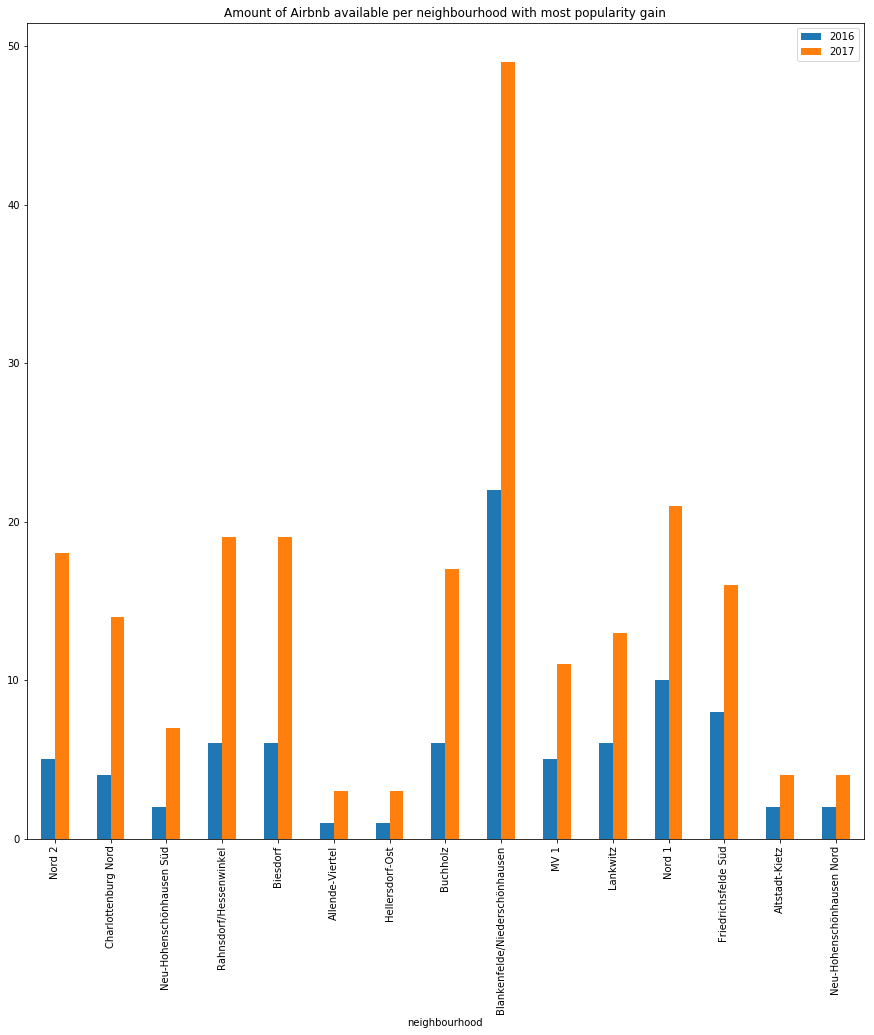

In [15]:
berlin_ng_stat_merge = berlin_ng_stat_merge.sort_values(by=['increase'], ascending=False)
berlin_ng_stat_merge.head(n=15).plot(x='neighbourhood', y = ['2016', '2017'], kind='bar', figsize=(15, 15), title="Amount of Airbnb available per neighbourhood with most popularity gain")
plt.show()

We can then map those data on the map of the city, we can observe that those neighbourhoods are not in the city center (and are even pretty far from the center of the city).

In [178]:
tmp = berlin_ng_stat_merge.sort_values(by='increase',ascending=False)
tmp = tmp.iloc[:15, :].reset_index()
tmp['counts'] = tmp['increase']
neighbourhood_map(folium.Map(
        location=[52.52437, 13.41053],
        zoom_start=11
    ), os.path.join(DATASETS_ROOT, "Berlin", "neighbourhoods.geojson"), tmp, "Increase ratio")

In the previous graphs we highlighted neighbourhoods in which the number of available Airbnb increased the most, we can do the same for the opposite statistic, that is to say, districts in which the number of available Airbnb decreased the most:

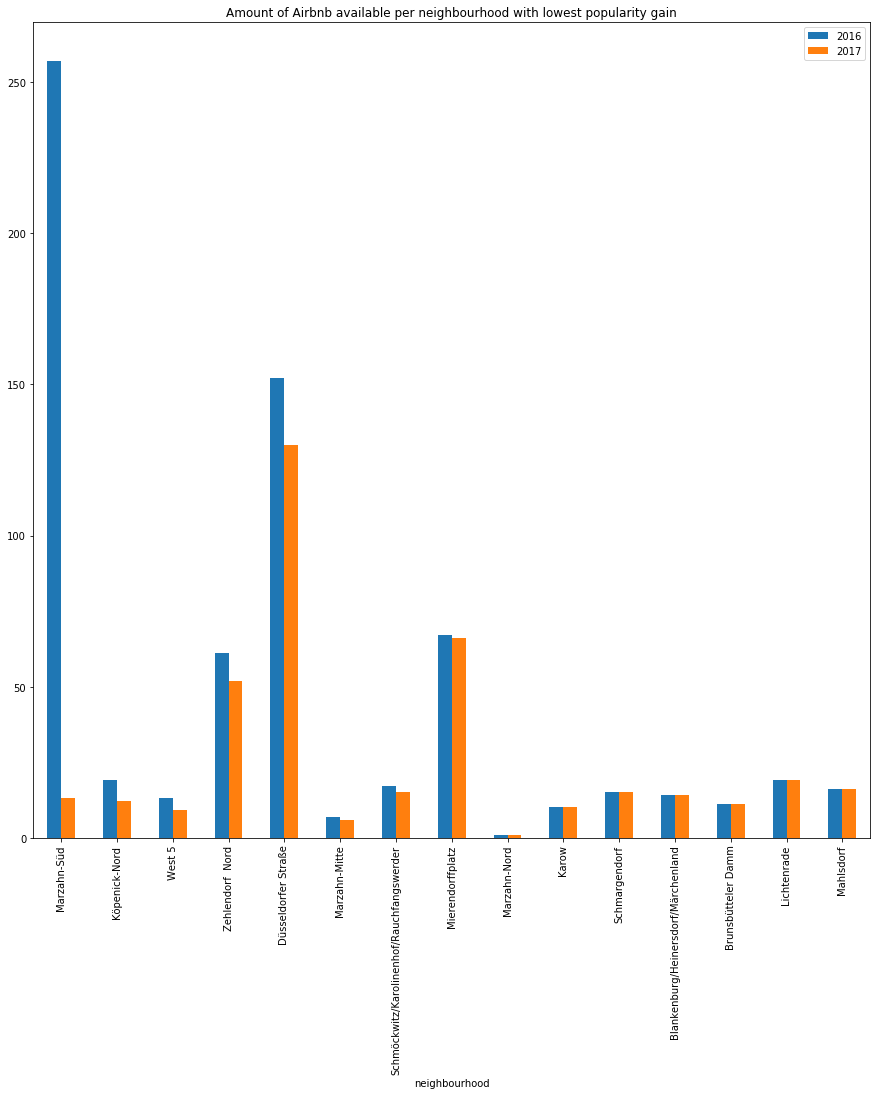

In [17]:
berlin_ng_stat_merge = berlin_ng_stat_merge.sort_values(by=['increase'], ascending=True)
berlin_ng_stat_merge.head(n=15).plot(x='neighbourhood', y = ['2016', '2017'], kind='bar', figsize=(15, 15), title="Amount of Airbnb available per neighbourhood with lowest popularity gain")

In [179]:
berlin_ng_stat_merge

neighbourhood  counts_x  counts_y  diff  \
71                                 Marzahn-Süd       257        13  -244   
60                               Köpenick-Nord        19        12    -7   
128                                     West 5        13         9    -4   
132                           Zehlendorf  Nord        61        52    -9   
27                         Düsseldorfer Straße       152       130   -22   
69                               Marzahn-Mitte         7         6    -1   
109  Schmöckwitz/Karolinenhof/Rauchfangswerder        17        15    -2   
72                            Mierendorffplatz        67        66    -1   
70                                Marzahn-Nord         1         1     0   
55                                       Karow        10        10     0   
108                              Schmargendorf        15        15     0   
13         Blankenburg/Heinersdorf/Märchenland        14        14     0   
19                          Brunsbütteler Damm        11        11     0   
63                                 Lichtenrade        19        19     0   
66                                   Mahlsdorf        16        16     0   
23                                 Buckow Nord         2         2     0   
116                              Teltower Damm        38        39     1   
87                                       Ost 2        35        36     1   
130                         Wiesbadener Straße        32        33     1   
10                                   Barstraße        58        60     2   
90                                  Pankow Süd       157       163     6   
129                                    Westend        68        71     3   
36                             Friedrichshagen        21        22     1   
42                                    Halensee        57        60     3   
51                                  Kantstraße       127       134     7   
17                            Brunnenstr. Nord       221       236    15   
89                             Otto-Suhr-Allee       133       143    10   
16                                       Britz        49        53     4   
33                                   Friedenau       135       147    12   
107                                 Schloßstr.        47        52     5   
..                                         ...       ...       ...   ...   
125                                     West 2        10        16     6   
37                              Gatow / Kladow        10        16     6   
0                                    Adlershof        13        21     8   
80                    Neuköllner Mitte/Zentrum       450       731   281   
25                                Dammvorstadt        11        18     7   
43                                  Haselhorst         3         5     2   
11                              Baumschulenweg        40        67    27   
56                                   Kaulsdorf         7        12     5   
5                    Alt-Hohenschönhausen Nord         4         7     3   
48                             Hellersdorf-Süd         4         7     3   
112            Schönholz/Wilhelmsruh/Rosenthal        10        18     8   
15                                   Bohnsdorf         5         9     4   
103                                      Rudow        21        38    17   
93                                 Plänterwald        28        51    23   
35                         Friedrichsfelde Süd         8        16     8   
77                   Neu-Hohenschönhausen Nord         2         4     2   
40                                      Grünau         3         6     3   
9                               Altstadt-Kietz         2         4     2   
82                                      Nord 1        10        21    11   
62                                    Lankwitz         6        13     7   
64                                        MV 1         5        11     6   
14   

In [180]:
tmp = berlin_ng_stat_merge.sort_values(by='increase', ascending=True)
tmp = tmp.iloc[:15, :].reset_index()
tmp['counts'] = tmp['increase']
neighbourhood_map(folium.Map(
        location=[52.52437, 13.41053],
        zoom_start=11
    ), os.path.join(DATASETS_ROOT, "Berlin", "neighbourhoods.geojson"), tmp, "decrease ratio")

As we can see those neighbourhoods are in fact as far from the city center than the one pictured above, hence we cannot really deduce anything regarding the location of the neigbourhoods the most influenced by Airbnb in Berlin.

We'll now focus on the number of available day per Airbnb, as we can see on the following graph, the number of Airbnb available less than 50 days per year increased a lot, and the number of highly available housins (full time airbnb) decreased. This could mean that more and more people are using Airbnb as a way to supplement their income (during their holdays or weekend for instance) more than using the service for `full time` rental.

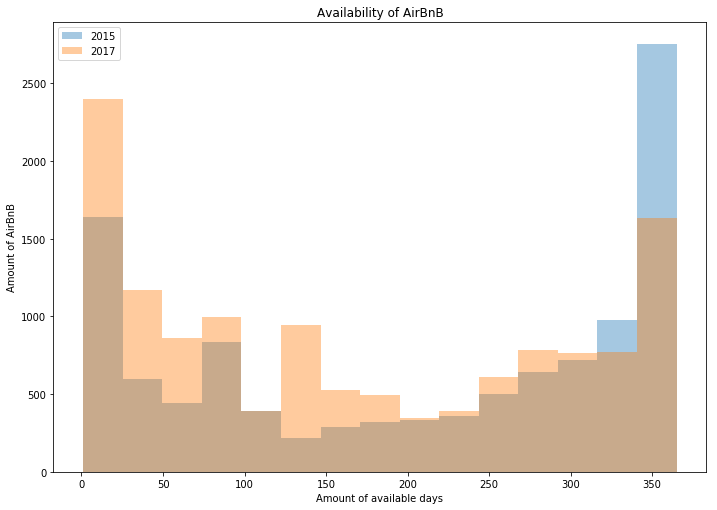

In [19]:
plot_availability_hist(berlin_calendar_data_2016, berlin_calendar_data_2017)

Now that we talked about location and availability, we are now going to focus ourself on one of the most important factor to people nowaday: money. From our data, we can extract the price of Airbnb in Berlin with respect to the year. This is exactly what the next graph shows:

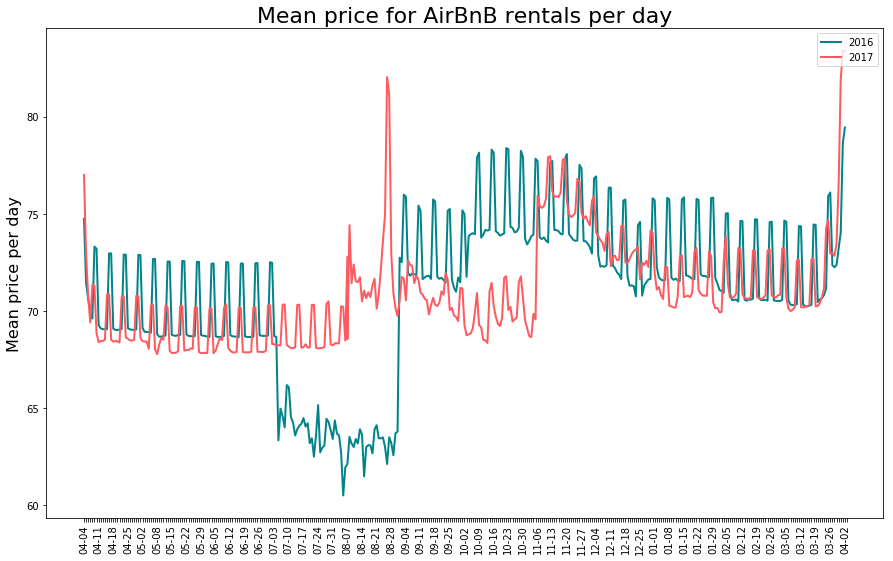

In [160]:
be_mean_price_16 = mean_prices(berlin_calendar_data_2016)
be_mean_price_17 = mean_prices(berlin_calendar_data_2017)

days = be_mean_price_16["date"].unique()
joined_date = pd.merge(be_mean_price_16, be_mean_price_17, on="date_wo_year").sort_values(by="date_wo_year")
plot_mean_prices(joined_date, label_1='2016', label_2='2017')

In [170]:
be_mean_price_17.sort_values(by='price', ascending=False)

date      price date_wo_year
237  2017-12-30  83.391212        12-30
238  2017-12-31  83.381834        12-31
19   2017-05-26  82.031071        05-26
236  2017-12-29  81.905348        12-29
20   2017-05-27  81.123426        05-27
97   2017-08-12  77.962170        08-12
96   2017-08-11  77.904223        08-11
104  2017-08-19  77.840036        08-19
103  2017-08-18  77.781365        08-18
239  2018-01-01  76.999515        01-01
110  2017-08-25  76.799325        08-25
111  2017-08-26  76.686806        08-26
235  2017-12-28  76.501141        12-28
98   2017-08-13  76.166978        08-13
102  2017-08-17  76.086811        08-17
91   2017-08-06  75.927641        08-06
100  2017-08-15  75.903527        08-15
118  2017-09-02  75.874628        09-02
101  2017-08-16  75.857381        08-16
99   2017-08-14  75.855228        08-14
95   2017-08-10  75.767636        08-10
117  2017-09-01  75.678153        09-01
105  2017-08-20  75.658441        08-20
94   2017-08-09  75.400387        08-09
92   2017-08-07  75.393640        08-07
93   2017-08-08  75.304852        08-08
112  2017-08-27  75.061164        08-27
109  2017-08-24  75.053345        08-24
106  2017-08-21  74.978098        08-21
18   2017-05-25  74.956500        05-25
..          ...        ...          ...
288  2018-02-19  67.991715        02-19
289  2018-02-20  67.985429        02-20
302  2018-03-05  67.972665        03-05
287  2018-02-18  67.960429        02-18
280  2018-02-11  67.958744        02-11
326  2018-03-29  67.957778        03-29
309  2018-03-12  67.955684        03-12
284  2018-02-15  67.929417        02-15
319  2018-03-22  67.903392        03-22
323  2018-03-26  67.901104        03-26
322  2018-03-25  67.897203        03-25
324  2018-03-27  67.890972        03-27
312  2018-03-15  67.889983        03-15
315  2018-03-18  67.889579        03-18
325  2018-03-28  67.889561        03-28
294  2018-02-25  67.885233        02-25
317  2018-03-20  67.875284        03-20
318  2018-03-21  67.874186        03-21
310  2018-03-13  67.872915        03-13
316  2018-03-19  67.871915        03-19
311  2018-03-14  67.870528        03-14
283  2018-02-14  67.851892        02-14
297  2018-02-28  67.850452        02-28
296  2018-02-27  67.842468        02-27
282  2018-02-13  67.841943        02-13
281  2018-02-12  67.837692        02-12
295  2018-02-26  67.834685        02-26
298  2018-03-01  67.833080        03-01
301  2018-03-04  67.828793        03-04
274  2018-02-05  67.778154        02-05

[366 rows x 3 columns]

We wasn't expecting that result, but it seems that the average price of Airbnb decreased between 2015 and 2017. Still, we can explain this using the previous graphs and data, indeed, as we saw, the number of available housing was multiplied by two in the same timespan, as the offer augments, the prices falls, this is quite a usual pattern.

However we weren't able to explain the drop during the summer 2015, it could be explain by an global event (people might be less willing to travel during a World cup or Olympic Game), terrorist attacks or natural disaster, but we couldn't find any of those in Berlin at this time.

###  Amsterdam - Inside Airbnb


In [21]:
amsterdam_listing_ng_names = amsterdam_listing_2015.neighbourhood.unique()
amsterdam_listing_2015_neig_stats = amsterdam_listing_2015.groupby("neighbourhood").size().reset_index(name="counts")

As we did for Berlin, this map shows the density of available Airbnb across the different neighbourhood of the city. There is not much to add here, the neighbourhoods in the center of the city have far more available housing than the one farther.

In [22]:
neighbourhood_map(folium.Map(
        location=[52.370216, 4.895168],
        zoom_start=12
    ), os.path.join(DATASETS_ROOT, "Amsterdam", "neighbourhoods.geojson"), amsterdam_listing_2015_neig_stats, "Number of available AirBnb")

The next plot shows the number of available AirBnB per number of night in Amsterdam.
This first thing we can notice on this graph is that the number of AirBnB increased a lot between 2015 and 2017, we can also observe that many AirBnb are only available for less than 100 days, compared to 2015 where most were available more than 250 days.

This can be explained by the regulation of AirBnb in Amsterdam that took place in 2017 where most of the AirBnB rentals were limited to at most 60 days.

Why are there still so many above 60 days ? This could be explain through the fact that those data only tells us when the place was available, not if it was rented during the whole time it is available.

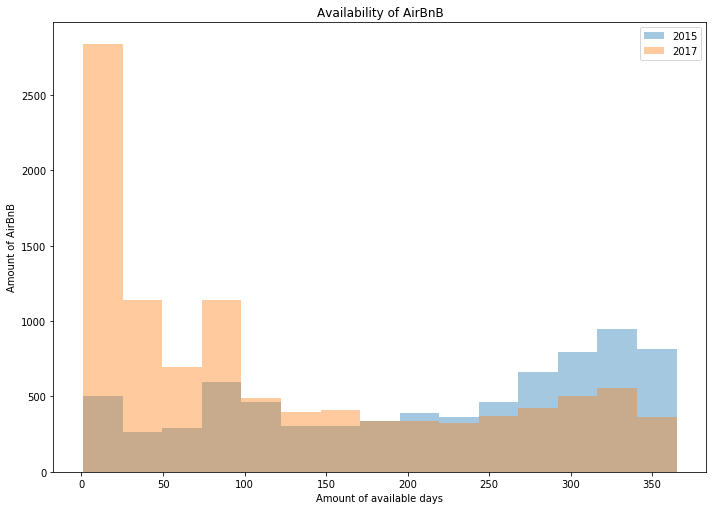

In [23]:
plot_availability_hist(amsterdam_calendar_data_2015, amsterdam_calendar_data_2017)

We explore a bit of temporal data to see how the service is used during one full year. We look at what has changed
between 2015 and 2017.

In [24]:
am_mean_price_15 = mean_prices(amsterdam_calendar_data_2015)
am_mean_price_17 = mean_prices(amsterdam_calendar_data_2017)

days = am_mean_price_15["date"].unique()

Now than we have the date without year column, we can merge the two dataframes using it and have the mean price per day in 2015 and 2017

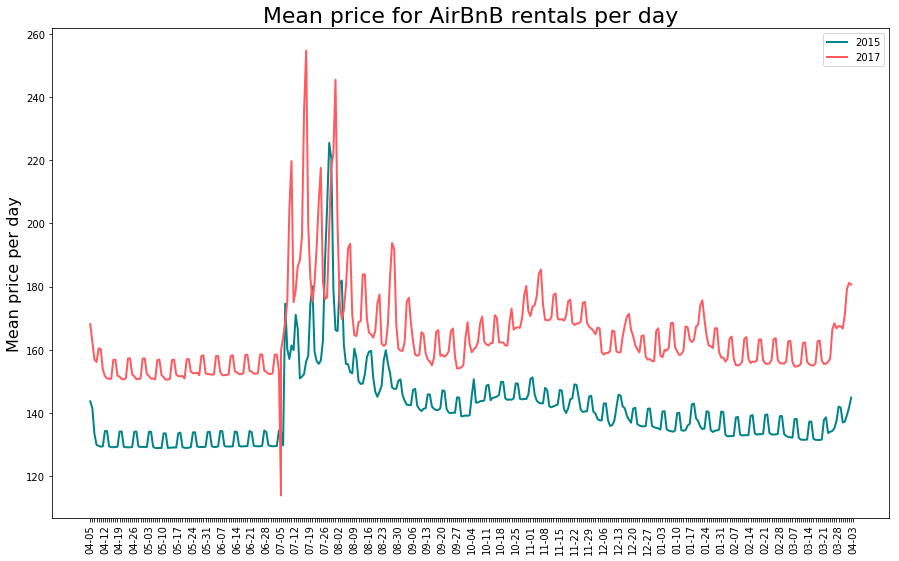

In [161]:
joined_date = pd.merge(am_mean_price_15, am_mean_price_17, on="date_wo_year").sort_values(by="date_wo_year")
plot_mean_prices(joined_date)

From those two graphs we can see a pattern, there are more or less 52 spikes corresponding to the number of weekends in the year. We can also see that April/May seems to be more attractive for people to travel, explaining the high prices during those months.

_TODO: Explain/Exploit results

Average percentage of augmentation

In [26]:
joined_date.sum()['price_y'] / joined_date.sum()['price_x'] * 100

116.61824178462426

In [27]:
ams_listing_2017_neig_stats = amsterdam_listing_2017.groupby("neighbourhood").size().reset_index(name="counts")
ams_listing_2015_neig_stats = amsterdam_listing_2015.groupby("neighbourhood").size().reset_index(name="counts")
ams_ng_stat_merge = ams_listing_2015_neig_stats.merge(ams_listing_2017_neig_stats, on='neighbourhood')
ams_ng_stat_merge['diff'] = ams_ng_stat_merge['counts_y'] - ams_ng_stat_merge['counts_x']
ams_ng_stat_merge['increase'] = ams_ng_stat_merge['counts_y'] / ams_ng_stat_merge['counts_x']
ams_ng_stat_merge['2015'] = ams_ng_stat_merge['counts_x']
ams_ng_stat_merge['2017'] = ams_ng_stat_merge['counts_y']

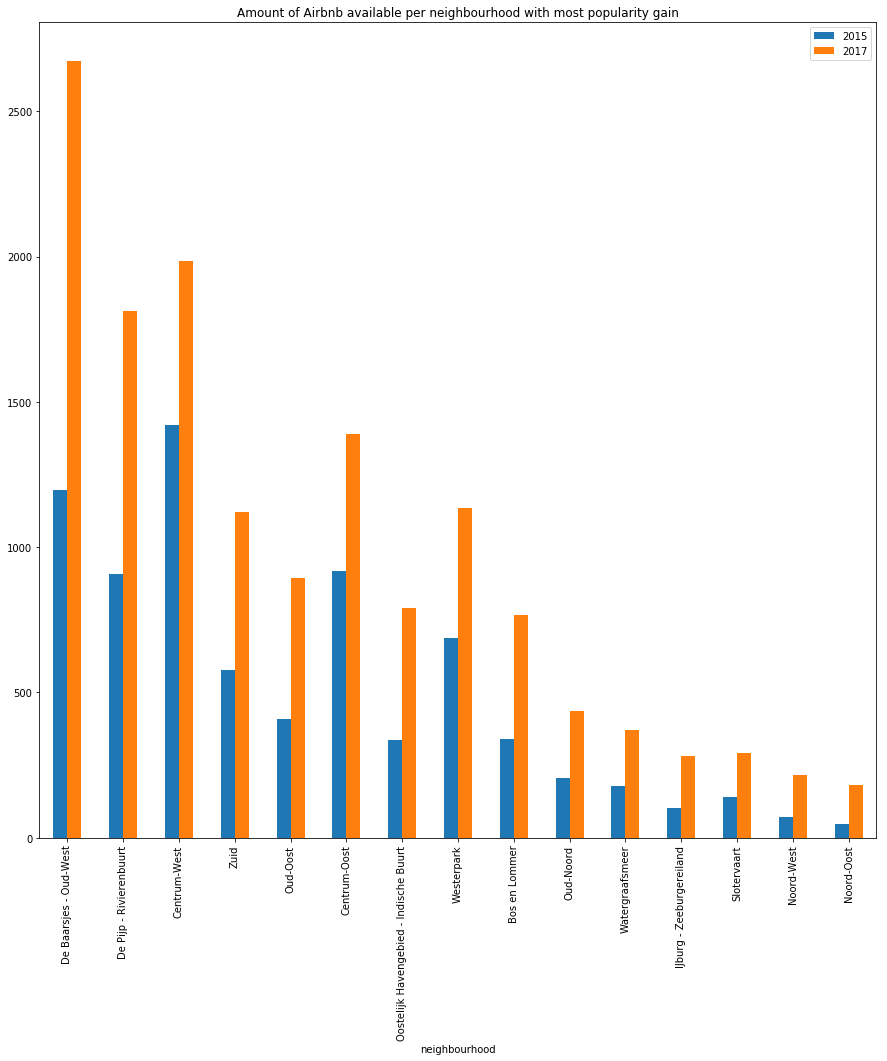

In [28]:
ams_ng_stat_merge = ams_ng_stat_merge.sort_values(by=['diff'], ascending=False)
ams_ng_stat_merge.head(n=15).plot(x='neighbourhood', y = ['2015', '2017'], kind='bar', figsize=(15, 15), title="Amount of Airbnb available per neighbourhood with most popularity gain")

In [29]:
len(ams_ng_stat_merge[ams_ng_stat_merge['diff'] < 0])

0

In the case of Amsterdam, all neighbourhoods gained in popularity (represented by the number of AirBnB available). 
Why this difference with Berlin ? Our guess is that Berlin is much more wide city than Amsterdam, and people using AirBnB seems to care beeing in the center, which makes no big difference in AirBnB but a lot in Berlin.

In [140]:
tmp = ams_ng_stat_merge
tmp = tmp.iloc[:5, :].reset_index()
tmp['counts'] = tmp['increase']

neighbourhood_map(folium.Map(
        location=[52.370216, 4.895168],
        zoom_start=12
), os.path.join(DATASETS_ROOT, "Amsterdam", "neighbourhoods.geojson"), tmp, "Increase ratio")


## National data imports

Now that we have an idea of the data taken from Airbnb, we'll focus ourself more on those coming from official ressources regarding the two cities.

For Berlin: https://daten.berlin.de/

For Amsterdam: https://data.overheid.nl/

In [31]:
def load_national_data(city, file_name):
    file = os.path.join(DATASETS_ROOT, city, NATIONAL, file_name)
    return pd.read_csv(file)

In [32]:
# Loading data for Amsterdam
am_2013_to_2017_number_of_housing = load_national_data("Amsterdam", "2013_to_2017_number_of_housing.csv")
am_2015_2016_total_sales_prices = load_national_data("Amsterdam", "2015_2016_total_sales_prices.csv")
am_2017_number_of_room_per_dwelling = load_national_data("Amsterdam", "2017_number_of_room_per_dwelling.csv")
am_2017_satisfaction_with_living_environment = load_national_data("Amsterdam", "2017_satisfaction_with_living_environment.csv")

am_2013_to_2017_number_of_housing['neighbourhood'] = am_2013_to_2017_number_of_housing['district']
am_2013_to_2017_number_of_housing = am_2013_to_2017_number_of_housing.sort_values('district')

In [33]:
# Loading data for Berlin (we couldn't find as much as we wanted)
be_2016_tourists_income = load_national_data("Berlin", "2016_tourists_income.csv")
be_2017_rental_price = load_national_data("Berlin", "2017_rental_price.csv")
be_overnight = load_national_data("Berlin", "2012_to_2016_overnight_stays.csv")

## Exploring data from national sources

### Berlin - National Data

As we analyse the price of Airbnb over time and have the data for Berlin, we'll analyse the price of housing over time in the city.

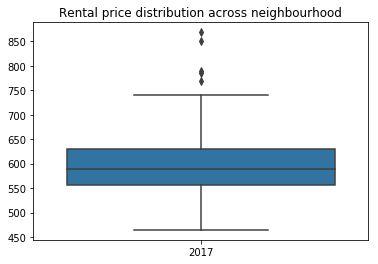

In [34]:
be_rental = be_2017_rental_price * 60 # because the data is in price per square meter for 60 square meters apartments

g = sns.boxplot(data=be_rental)
g.set_xticklabels(['2017'])
g.set_title('Rental price distribution across neighbourhood')
plt.show()

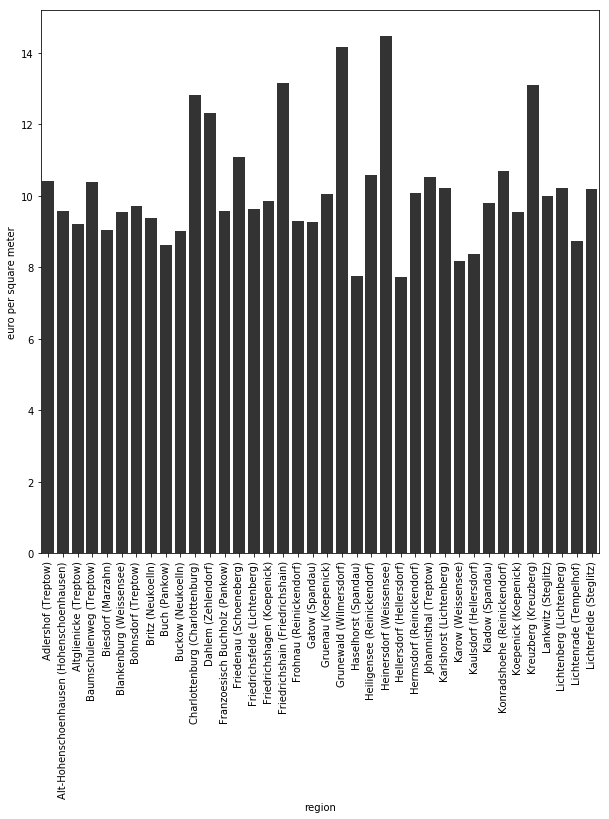

In [35]:
fig, ax = plt.subplots(figsize=(10, 10))
g = sns.barplot(data=be_2017_rental_price, x='region', y='euro per square meter', ax=ax, color="#333333FF")
g.set_xticklabels(be_2017_rental_price['region'], rotation=90)
plt.show(g)

_TODO: We will be able to use those prices per neighbourhood in comparison with Inside Airbnb data._

Size of apartments in different neighbourhoods.


In [36]:
berlin_listing_2016_full['square_feet'].mean()

434.76061320754718

Rental price categories for private housing.


Relation to tourists

In [185]:
be_2016_tourists_income
berlin_mapped_2016

id                                 name   host_id  \
0      8105601             QUIET AND FRIENDLY PLACE  42794938   
1       240735                       I want Berlin!   1262812   
2      4056601  Ferienhaus - 20 Minuten in die City  21038534   
3      2784176  Berlin Studio ruhige Lage U-Bahnnah  14198674   
4       725992   Friendly, little room wait for you   3755786   
5     11010163   Ferienhaus Eggert Bett im Kornfeld  57133876   
6      5813027   Altbauschmuckstück zum Wohlfühlen!   7739524   
7       455428  Schöne Dachgeschosswohnung für 7 P.   1504376   
8      4643298                            Casa Rosa  24039871   
9      2888184            64 qm im Norden mit Stil    5109792   
10     9781655       Sonnige Dachwohnung mit Balkon  11036645   
11     3996883  Quiet, sunny room with roof-terrace  20720860   
12     2906876           Exclusive house with flair  14146305   
13      380384      Newly renovated apartment, 44qm   1908382   
14      279268  Friedrich´s Apartment Reinickendorf   1456530   
15     8603924            City Apartment mit Balkon   1504376   
16     2954558  central, large, stylish, convenient   2902503   
17      245906  F'hain Flat Next to Xberg and Mitte   1289756   
18    10941636  Family-friendly + near to the party  56732023   
19    10536399         Friedrichshain! Supergünstig  53732551   
20     1493899    2 room apartment on the Stalinbau   7984696   
21     6635677    cute cosy vintage roof  apartment   3031275   
22     8832045     Central in Berlin Friedrichshain  29913140   
23     4170991     36qm Apartment in Friedrichshain  21643833   
24     8005367  Möblierte Wohnung in Friedrichshain   7148970   
25     6447116  Ruhige helle whg. in Friedrichshain   2044023   
26     7249918    Zentral & ruhig im hippen F-hain!   5864839   
27      639830    Berlin Loft beautiful and central   2388572   
28     2029998    Beautifull Flat in Central Berlin  10407307   
29    12069890   Whole flat in the middle of Fhain!  11118498   
...        ...                                  ...       ...   
6796   4680046         Small but GOLD SPECIAL OFFER  16079116   
6797  11830113                             Sunshine  63028268   
6798   7482207   NEUKÖLLN/furnished near Ubahn/mall  39180233   
6799   2504590   COSY NEST WITH BALCONY IN NEUKÖLLN   3980729   
6800    714312     Sunny Apartment near subway WIFI   3678837   
6801   8021258     Moderne Wohnung im Süden Berlins  39156794   
6802   1740713         FeWo für 5 Personen mit 90m²   9098687   
6803   6888269  Große & helle Wohnung in Süd-Berlin  24993897   
6804   1971657   Gropiusstadt Neukölln with Balcony    901417   
6805   7455743         Modern eingerichtete Wohnung  39047339   
6806    190448      Modernes Studioapartment Berlin    920085   
6807    237670                    Apartment Burde 2    920085   
6808   1032446           Quiet, cosy Room with bath   5565633   
6809   8468463   Ruhig, grün & trotzdem nah am Puls  44597161   
6810    396901            Neu möbliertes Apartement   1267997   
6811   2498186           Sunny Flat in South Berlin  12787275   
6812   6827357                  Room for 1-2 people  23880492   
6813   2700880  Glückliche Wohnung Berlin-Adlershof  13820913   
6814   1614414     Apartment with easy connections.    901417   
6815   7626956       Nice Room in South-East Berlin  36608618   
6816  10846046                           Maisonette  56174983   
6817   9268291     Entire Apartment in the old city   1711714   
6818  10985395                   bed in shared room  30778641   
6819  11884860                1-Room Flat in Berlin  63374675   
6820  11274920                    Flat in Adlershof  58871579   
6821   5040353  Big, cheap and comfortable room :-)   1644092   
6822   1674415  Comfortable room close to the green   1661133   
6823    817372     Apartment "Gardens of the World"   4293269   
6824   4399196  Sehr gut gelegene 73qm/3 Zimmerwohn  22837630   
6825   3495631  Apartment of character, close m

### Amsterdam - National Data

Analysis of the price of housing over time.

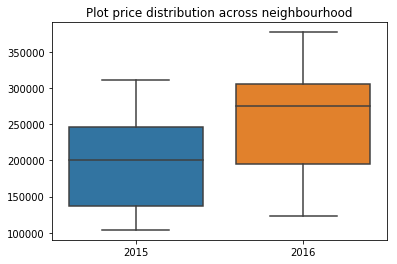

In [37]:
am_sales_prices = am_2015_2016_total_sales_prices[['district', 'average price of plots 2015', 'average price of plots 2016']]
am_sales_prices = am_sales_prices 

g = sns.boxplot(data=am_sales_prices)
g.set_xticklabels(['2015', '2016'])
g.set_title('Plot price distribution across neighbourhood')
plt.show(g)

Percentage of average augmentation :

In [39]:
am_sales_prices.sum()['average price of plots 2016'] / am_sales_prices.sum()['average price of plots 2015'] * 100

130.9868007542426

From this we see that the prices increase over time. We will later compare this per neighbourhood and compare it to the data from Inside Airbnb.

Size of apartments in different neighbourhoods.

Rental price categories for private housing.


Satisfaction with house and living environment per district.


## Combining and comparing the results

Finding correlation between national and Inside Airbnb data

### Mapping Neighbourhoods across data

In the data from AirBnb, neighourhoods are splitted into much more smaller pieces than on the data from official websites (for both Berlin and Amsterdam), in order to compare them we had to create a mapping between those neighbourhoods, this is located inside the `berlin_map_neighbourhoods.csv` and `asmterdam_map_neighbourhoods.csv`

#### Amsterdam


In [40]:
# Load CSV
# Join with the Inside AirBnb dataframe
# Join the result with the official city dataframe
def load_mapping_city_neighbourhoods(city):
    am_neigh_mapping_file = os.path.join(DATASETS_ROOT, city, "neighbourhood_map.csv")
    tmp = pd.read_csv(am_neigh_mapping_file)
    tmp['neighbourhood'] = tmp['airbnb_name']
    return tmp


In [41]:
amsterdam_mapping = load_mapping_city_neighbourhoods("Amsterdam")
amsterdam_mapped_2017 = amsterdam_listing_2017.merge(amsterdam_mapping, on='neighbourhood')
amsterdam_mapped_2015 = amsterdam_listing_2015.merge(amsterdam_mapping, on='neighbourhood')

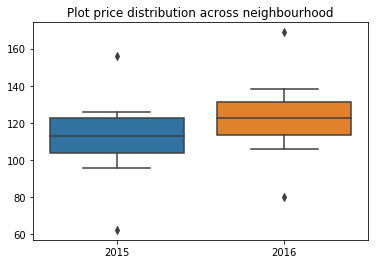

In [42]:
tmp = amsterdam_mapped_2015.groupby('official_name')[['price']].mean()
tmp['price_2016'] = amsterdam_mapped_2017.groupby('official_name')[['price']].mean()

g = sns.boxplot(data=tmp)

g.set_title('Plot price distribution across neighbourhood')
g.set_xticklabels(['2015', '2016'])
plt.show(g)

In the following graph we drew a heatmap of the correlation between the number of available Airbnb per neighbourhood and some happiness criterium in each of them. As we can observe, the correlation between this number and the `grade` of the neighbourhood is weak, this seems to show thhat people using Airbnb do not really care a about the neigbourhood.

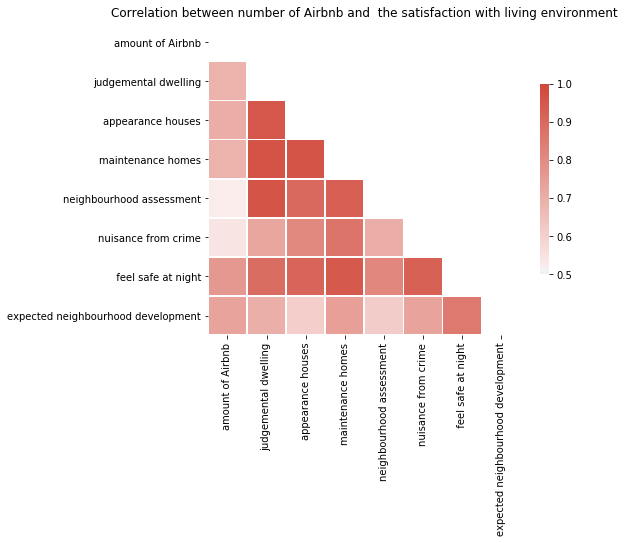

In [43]:
am_2017_satisfaction_with_living_environment['neighbourhood'] = am_2017_satisfaction_with_living_environment['distrrict']


t = amsterdam_mapped_2015.groupby('official_name').size().reset_index(name='counts')
t.columns = ['neighbourhood', 'amount of Airbnb']

t = t.merge(am_2017_satisfaction_with_living_environment, on='neighbourhood').sort_values('amount of Airbnb', ascending=False) #.iloc[:, :4]
del t['distrrict']
del t['total judgment']

corr = t.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(7, 7))

cmap = sns.diverging_palette(220, 15, as_cmap=True, n=2)

sns.heatmap(corr, mask=mask, cmap=cmap, vmin=0.5, vmax=1, center=0.5,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlation between number of Airbnb and  the satisfaction with living environment")
plt.show()

In [44]:
count_am_2015 = amsterdam_mapped_2015.groupby('official_name').size().reset_index(name='counts')
count_am_2017 = amsterdam_mapped_2017.groupby('official_name').size().reset_index(name='counts')

count_am_2015.columns = ['neighbourhood', 'amount of Airbnb 2015']
count_am_2017.columns = ['neighbourhood', 'amount of Airbnb 2017']

count_am_2015 = count_am_2015.sort_values('neighbourhood')
count_am_2017 = count_am_2017.sort_values('neighbourhood')

wo_wesport = am_2013_to_2017_number_of_housing[~am_2013_to_2017_number_of_housing['neighbourhood'].str.contains("Westpoort")].reset_index()
count_am_2015 = count_am_2015.join(wo_wesport, rsuffix='_right')[['neighbourhood', '2015', '2017', 'amount of Airbnb 2015']]
count_am = count_am_2015.merge(count_am_2017, on='neighbourhood')

count_am['wo_airbnb_2015'] = count_am['2015'] - count_am['amount of Airbnb 2015']
count_am['wo_airbnb_2017'] = count_am['2017'] - count_am['amount of Airbnb 2017']

tmp = count_am[['amount of Airbnb 2015', 'wo_airbnb_2015', 'amount of Airbnb 2017', 'wo_airbnb_2017']].sum()
count_am = count_am.append({'neighbourhood': 'Amsterdam', 'amount of Airbnb 2015': tmp['amount of Airbnb 2015'], 'wo_airbnb_2015' : tmp['wo_airbnb_2015'],
                           'amount of Airbnb 2017': tmp['amount of Airbnb 2017'], 'wo_airbnb_2017' : tmp['wo_airbnb_2017']}, ignore_index=True)

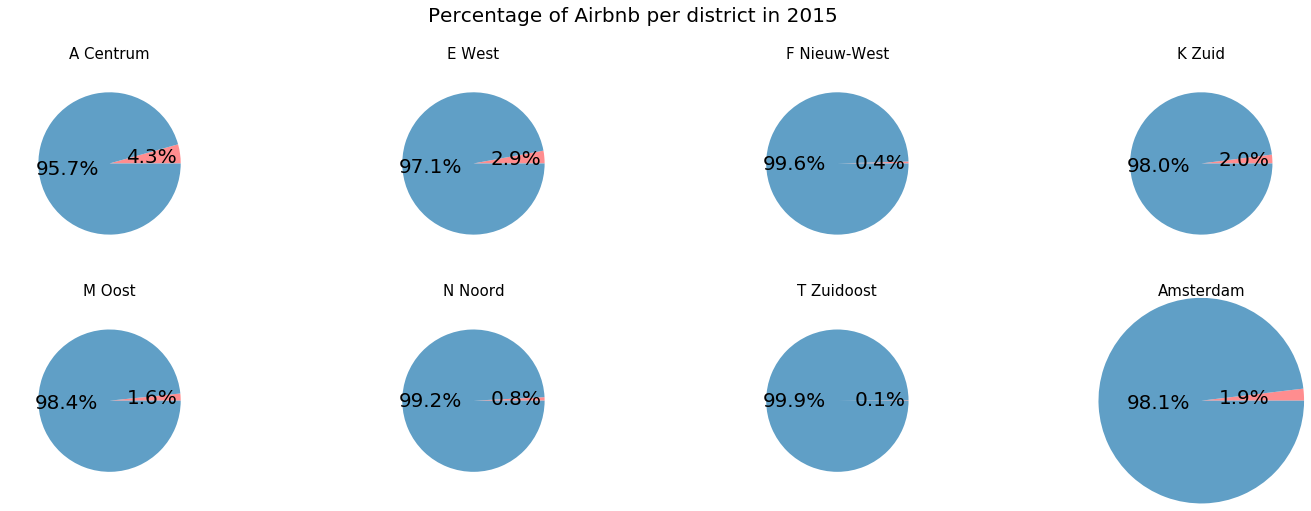

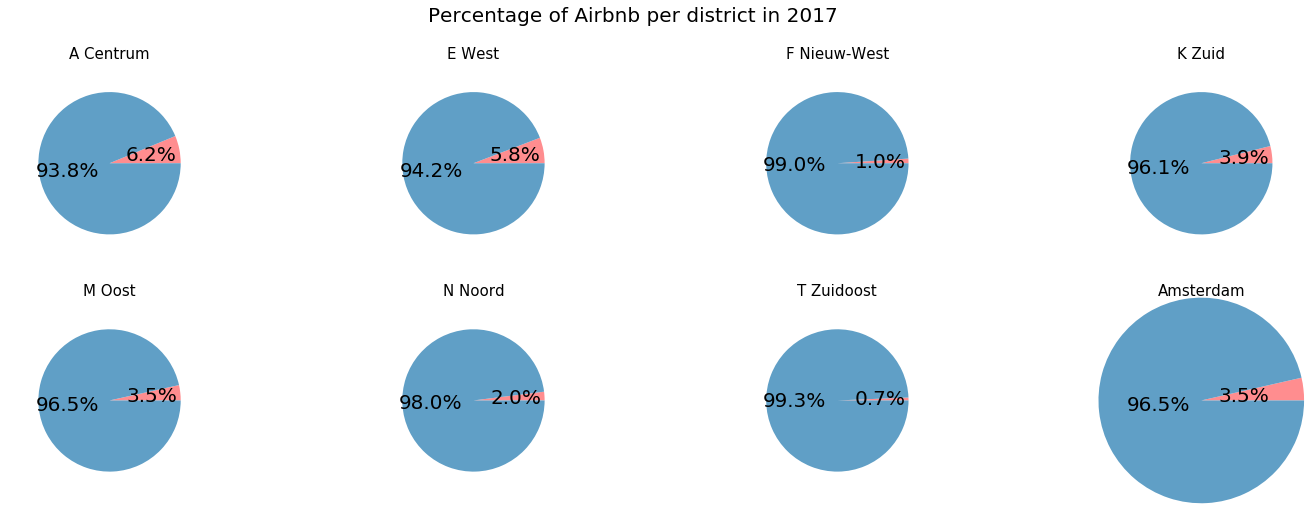

In [151]:
def plot_chart_by_year(df, year):
    plt.figure(1, figsize=(25, 8))
    plt.suptitle('Percentage of Airbnb per district in ' + year, fontsize=20)

    p = None
    for i in range(len(df)):
        plt.subplot(2, 4, i+1, aspect=1)
        p, txts, autotexts = plt.pie(df[['amount of Airbnb ' + year, 'wo_airbnb_' + year]].T[i], colors=["#ff8d8f", "#609fc6"], radius=0.9, autopct='%1.1f%%')
        autotexts[0].set_fontsize(20)
        autotexts[1].set_fontsize(20)

        plt.title(df['neighbourhood'][i], fontsize=15)

    p[0].set_radius(1.3)
    p[1].set_radius(1.3)
    plt.show()

plot_chart_by_year(count_am, "2015")
plot_chart_by_year(count_am, "2017")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


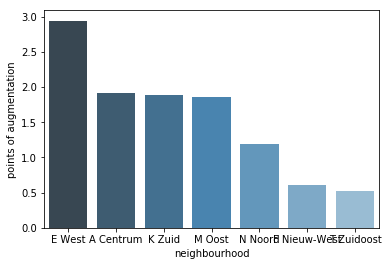

In [206]:
# count_am_t = count_am[count_am['neighbourhood'] != 'Amsterdam']

augm_count_am = count_am[['neighbourhood']]
augm_count_am['points of augmentation'] = (count_am['amount of Airbnb 2017'] / count_am['2017'] - count_am['amount of Airbnb 2015'] / count_am['2015']) * 100
augm_count_am = augm_count_am[augm_count_am['neighbourhood'] != 'Amsterdam']
augm_count_am = augm_count_am.sort_values(by='points of augmentation', ascending=False)

sns.barplot(x='neighbourhood', y='points of augmentation', data=augm_count_am, palette='Blues_d')

In [46]:
avg_prices = am_sales_prices.copy()
avg_prices.index = avg_prices['district']

v = ams_ng_stat_merge.merge(amsterdam_mapping)
v = v.groupby('official_name').mean()
v = v.join(avg_prices)

v['diff_plot_price'] = v['average price of plots 2016'] - v['average price of plots 2015']
v

counts_x     counts_y        diff  increase         2015  \
official_name                                                                
A Centrum      1169.000000  1687.000000  518.000000  1.455813  1169.000000   
E West          740.666667  1524.333333  783.666667  2.048287   740.666667   
F Nieuw-West     70.750000   169.500000   98.750000  2.579055    70.750000   
K Zuid          522.333333  1039.333333  517.000000  2.051787   522.333333   
M Oost          256.750000   584.250000  327.500000  2.342694   256.750000   
N Noord         108.333333   278.000000  169.666667  2.988345   108.333333   
T Zuidoost       17.000000    89.000000   72.000000  5.881536    17.000000   

                      2017      district  average price of plots 2015  \
official_name                                                           
A Centrum      1687.000000     A Centrum                       311000   
E West         1524.333333        E West                       231000   
F Nieuw-West    169.500000  F Nieuw-West                       108000   
K Zuid         1039.333333        K Zuid                       289000   
M Oost          584.250000        M Oost                       205000   
N Noord         278.000000       N Noord                       147000   
T Zuidoost       89.000000    T Zuidoost                       104000   

               average price of plots 2016  diff_plot_price  
official_name                                                
A Centrum                           377000            66000  
E West                              281000            50000  
F Nieuw-West                        187000            79000  
K Zuid                              365000            76000  
M Oost                              268000            63000  
N Noord                             197000            50000  
T Zuidoost                          123000            19000

In [47]:
v.corr()

counts_x  counts_y      diff  increase      2015  \
counts_x                     1.000000  0.971331  0.806371 -0.667381  1.000000   
counts_y                     0.971331  1.000000  0.923850 -0.693726  0.971331   
diff                         0.806371  0.923850  1.000000 -0.651294  0.806371   
increase                    -0.667381 -0.693726 -0.651294  1.000000 -0.667381   
2015                         1.000000  0.971331  0.806371 -0.667381  1.000000   
2017                         0.971331  1.000000  0.923850 -0.693726  0.971331   
average price of plots 2015  0.888059  0.898347  0.805036 -0.723781  0.888059   
average price of plots 2016  0.850020  0.857642  0.765018 -0.819437  0.850020   
diff_plot_price              0.294164  0.287309  0.241132 -0.823916  0.294164   

                                 2017  average price of plots 2015  \
counts_x                     0.971331                     0.888059   
counts_y                     1.000000                     0.898347   
diff                         0.923850                     0.805036   
increase                    -0.693726                    -0.723781   
2015                         0.971331                     0.888059   
2017                         1.000000                     0.898347   
average price of plots 2015  0.898347                     1.000000   
average price of plots 2016  0.857642                     0.980875   
diff_plot_price              0.287309                     0.440594   

                             average price of plots 2016  diff_plot_price  
counts_x                                        0.850020         0.294164  
counts_y                                        0.857642         0.287309  
diff                                            0.765018         0.241132  
increase                                       -0.819437        -0.823916  
2015                                            0.850020         0.294164  
2017                                            0.857642         0.287309  
average price of plots 2015                     0.980875         0.440594  
average price of plots 2016                     1.000000         0.606896  
diff_plot_price                                 0.606896         1.000000

#### Berlin

In [48]:
berlin_mapping = load_mapping_city_neighbourhoods("Berlin")
berlin_mapped_2016 = berlin_listing_2016.merge(berlin_mapping, on='neighbourhood')
berlin_mapped_2017 = berlin_listing_2017.merge(berlin_mapping, on='neighbourhood')

berlin_mapped_2016_full = berlin_listing_2016_full.merge(berlin_mapping, on='neighbourhood')
berlin_mapped_2017_full = berlin_listing_2017_full.merge(berlin_mapping, on='neighbourhood')

-- *TODO* compare tourist income with airbnb increase

-- *TODO* corelation airbnb and rental price

-- *Todo* compare overnight with airbnb growth

In [188]:
be_2016_tourists_income
# Couldn't make a graph, but the amount of Airbnb in berlin between 2015 and 2017 is ~ *2, which is more or less the same as 
# the average change
be_2016_tourists_income.mean()['change since last year']

origin tourist amount  change since last year guest nights  \
0        Germany      7.687.753                     2.4   16.888.504   
1        Outside      5.043.887                     3.7   14.179.271   
2    from Europe      3.596.878                     4.2    9.936.861   
3  from Americas        618.826                     0.7    1.833.176   
4      from Asia        481.895                     0.9    1.459.604   
5    Alltogether     12.731.640                     2.9   31.067.775   

   change in nights  
0               1.7  
1               3.9  
2               4.0  
3               2.7  
4               2.3  
5               2.7

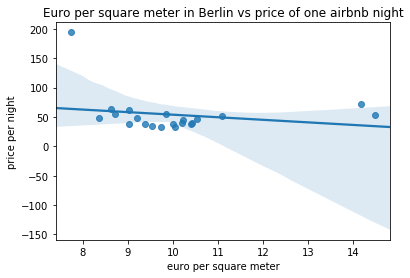

In [205]:
be_2017_rental_price['official_name'] = be_2017_rental_price['region']
tmp = be_2017_rental_price.merge(berlin_mapped_2017_full, on='official_name')
tmp["price per night"] = tmp["price"].apply(lambda p: p if isinstance(p, float) else float(p.replace('$', '').replace(',', '')))
tmp = tmp.groupby('official_name').mean()
ax = sns.regplot(x="euro per square meter", y="price per night", data=tmp)

plt.title("Euro per square meter in Berlin vs price of one airbnb night")
plt.show()


In [51]:
be_overnight

year  total overnight stays  overnight stays from germany  \
0  2012               24900000                      14310000   
1  2013               26940000                      15380000   
2  2014               28690000                      16190000   
3  2015               30250000                      16600000   
4  2017               31070000                      16890000   

   total overnight stays from abroad  \
0                           10590000   
1                           11560000   
2                           12500000   
3                           13650000   
4                           14180000   

   overnight stays from europe withour germany  
0                                      7790000  
1                                      8370000  
2                                      8970000  
3                                      9560000  
4                                      9940000

## Conclusion

One interesting challenge with this project was to gather data from website in other languages. German was still okay for us - even if the vocabulary was quite technical sometimes. Gathering data from a dutch website was more challenging, but automatic translation tools helped us.

In this work, we learned that […]